## Model validation on the Iris dataset

### Instructions

In this notebook, I had build, compile and fit a neural network model to the Iris dataset. You will also implement validation, regularisation and callbacks to improve your model.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
%matplotlib inline

# If you would like to make further imports from tensorflow, add them here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

#### The Iris dataset

In this assignment, you will use the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For a reference, see the following papers:

- R. A. Fisher. "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188, 1936.

Goal is to construct a neural network that classifies each sample into the correct class, as well as applying validation and regularisation techniques.

In [2]:
def read_in_and_split_data(iris_data):

    a,b,c,d=model_selection.train_test_split(iris_data['data'],iris_data['target'],test_size=0.1)
    return a,b,c,d

In [3]:
# Run function to generate the test and training data.

iris_data = datasets.load_iris()
train_data, test_data, train_targets, test_targets = read_in_and_split_data(iris_data)

We will now convert the training and test targets using a one hot encoder.

In [4]:
# Convert targets to a one-hot encoding

train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

#### Build the neural network model


In [6]:
def get_model(input_shape):

    model=Sequential([
        Dense(64,activation='relu',
              kernel_initializer='he_uniform',bias_initializer='ones',input_shape=input_shape),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(3,activation='softmax')
    ])

    return model

In [7]:
# Run function to get the model

model = get_model(train_data[0].shape)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 64)                4

#### Compile the model

Compile the model using the 'compile' method. Remember that, need to specify an optimizer, a loss function and a metric to judge the performance of your model.

In [9]:
def compile_model(model):

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
# Run your function to compile the model

compile_model(model)

#### Fit the model to the training data

* Run the training for a fixed number of epochs, given by the function's `epochs` argument.
* Return the training history to be used for plotting the learning curves.
* Set the batch size to 40.
* Set the validation set to be 15% of the training set.


In [11]:
def train_model(model, train_data, train_targets, epochs):

    history=model.fit(train_data,train_targets,epochs=epochs,verbose=False,
                      batch_size=40,validation_split=0.15)

    return history

In [12]:
# Run function to train the model

history = train_model(model, train_data, train_targets, epochs=800)

#### Plot the learning curves

We will now plot two graphs:
* Epoch vs accuracy
* Epoch vs loss


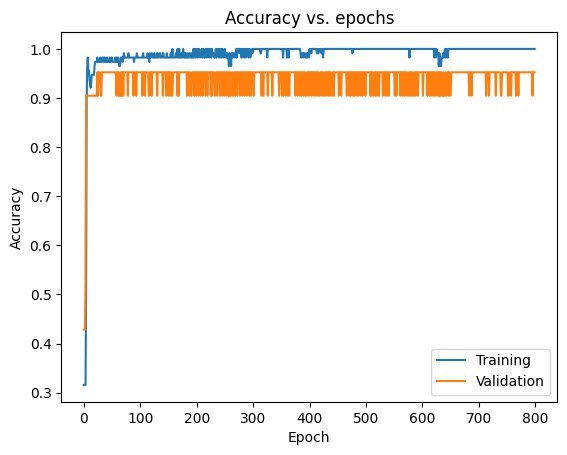

In [13]:
#Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

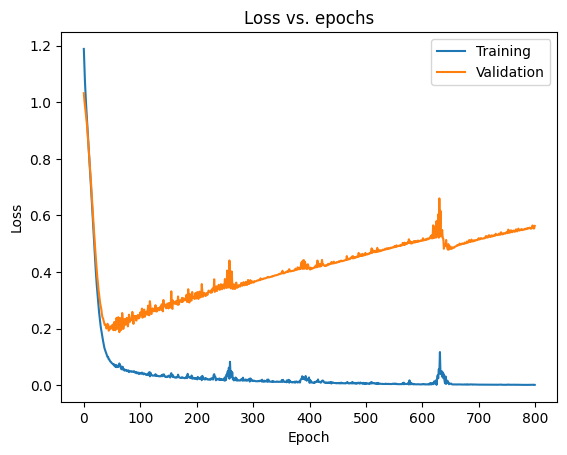

In [14]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Oh no! We have overfit our dataset. So we should now try to mitigate this overfitting.

#### Reducing overfitting in the model

Defining a new regularised model.
The specs for the regularised model are the same as our original model, with the addition of two dropout layers, weight decay, and a batch normalisation layer.

In particular:

* Add a dropout layer after the 3rd Dense layer
* Then there should be two more Dense layers with 128 units before a batch normalisation layer
* Following this, two more Dense layers with 64 units and then another Dropout layer
* Two more Dense layers with 64 units and then the final 3-way softmax layer
* Add weight decay (l2 kernel regularisation) in all Dense layers except the final softmax layer

In [15]:
def get_regularised_model(input_shape, dropout_rate, weight_decay):
    """
    This function should build a regularised Sequential model according to the above specification.
    The dropout_rate argument in the function should be used to set the Dropout rate for all Dropout layers.
    L2 kernel regularisation (weight decay) should be added using the weight_decay argument to
    set the weight decay coefficient in all Dense layers that use L2 regularisation.
    Ensure the weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument input_shape.
    Your function should return the model.
    """

    model=Sequential([
        Dense(64,kernel_initializer='he_uniform',
              activation='relu',
              bias_initializer='ones',input_shape=input_shape,
              kernel_regularizer=regularizers.l2(weight_decay),
              bias_regularizer=regularizers.l2(weight_decay)),
        Dense(128,activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(128,activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)),
        Dropout(rate=dropout_rate),
        Dense(128,activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(128,activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        BatchNormalization(),
        Dense(64,activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(64,activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)),
        Dropout(rate=dropout_rate),
        Dense(64,activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(64,activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(3,activation='softmax')
    ])

    return model

#### Instantiate, compile and train the model

In [16]:
# Instantiate the model, using a dropout rate of 0.3 and weight decay coefficient of 0.001

reg_model = get_regularised_model(train_data[0].shape, 0.3, 0.001)

In [17]:
# Compile the model

compile_model(reg_model)

In [18]:
# Train the model

reg_history = train_model(reg_model, train_data, train_targets, epochs=800)

#### Plot the learning curves

Let's now plot the loss and accuracy for the training and validation sets.

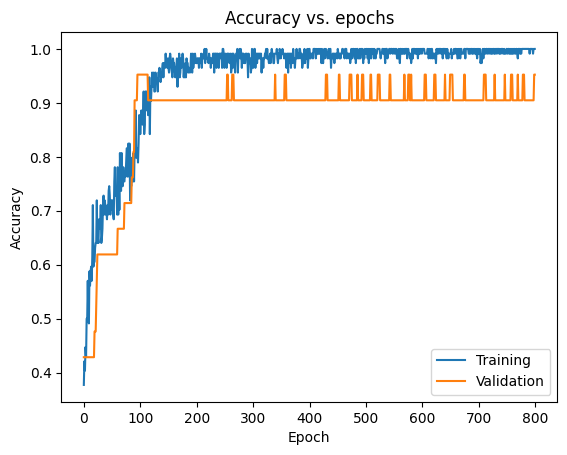

In [19]:
#Run this cell to plot the new accuracy vs epoch graph

try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

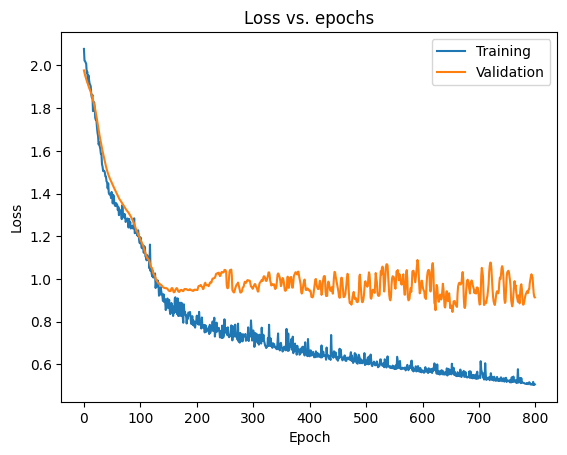

In [20]:
#Run this cell to plot the new loss vs epoch graph

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

We can see that the regularisation has helped to reduce the overfitting of the network.
Now incorporate callbacks into a new training run that implements early stopping and learning rate reduction on plateaux.

In [21]:
def get_callbacks():
    """
    This function should create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    """

    early_stopping=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        mode='min'
    )

    learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=20
    )

    return (early_stopping,learning_rate_reduction)

Run the cell below to instantiate and train the regularised model with the callbacks.

In [22]:
call_model = get_regularised_model(train_data[0].shape, 0.3, 0.0001)
compile_model(call_model)
early_stopping, learning_rate_reduction = get_callbacks()
call_history = call_model.fit(train_data, train_targets, epochs=800, validation_split=0.15,
                         callbacks=[early_stopping, learning_rate_reduction], verbose=0)

In [24]:
learning_rate_reduction.patience

20

Finally, let's replot the accuracy and loss graphs for our new model.

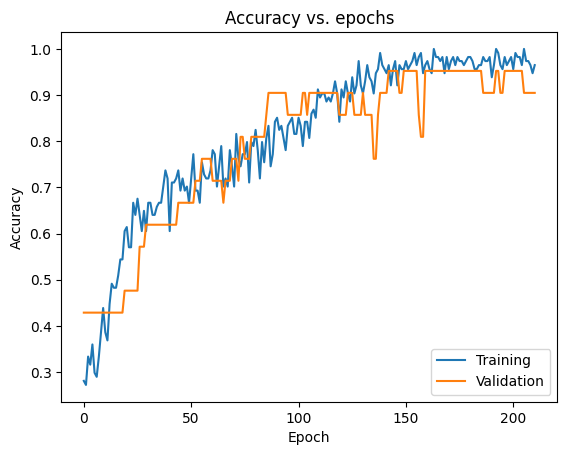

In [25]:
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

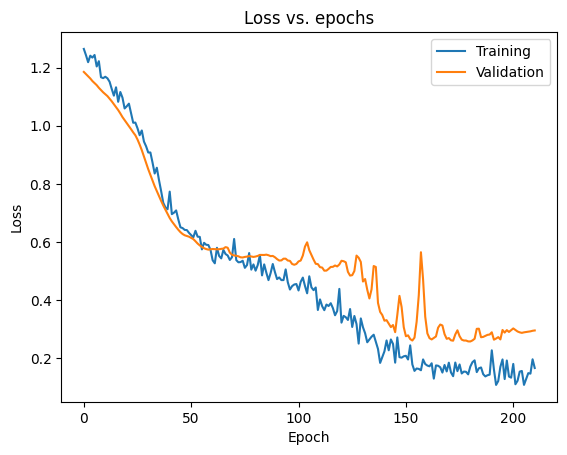

In [26]:
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [27]:
# Evaluate the model on the test set

test_loss, test_acc = call_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.107
Test accuracy: 100.00%
